<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

В данной работе была поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

За основу был взят обучающий датасет, найденный по ссылке https://github.com/Aleorate/skillfactory_rds/tree/master/module_7_Car_price_prediction_parse. Работа выполнялась в одиночку.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Data

In [5]:
train = pd.read_csv('cars_from_auto_ru_06_02.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1993,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,93000.0,2021-01-07T10:58:58Z,NaN,100
1,Седан,AUDI,97948F,бензин,1988.0,1.8 MT (88 л.с.),4.0,1988,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,115000.0,2021-02-02T13:01:30Z,NaN,100
2,Седан,AUDI,FAFBFB,бензин,1982.0,1.8 MT (90 л.с.),4.0,1987,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,2.0,ORIGINAL,True,"{'year': 2020, 'month': 6}",65000.0,2021-02-04T20:33:01Z,NaN,100
3,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,SEDAN MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,2.0,ORIGINAL,True,NaN,210000.0,2021-01-31T15:42:19Z,NaN,100
4,Седан,AUDI,EE1D19,бензин,1990.0,2.0 MT (115 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,130000.0,2020-07-18T09:51:29Z,NaN,100


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74796 entries, 0 to 74795
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              74794 non-null  object 
 1   brand                 74796 non-null  object 
 2   color                 74796 non-null  object 
 3   fuelType              74796 non-null  object 
 4   modelDate             74794 non-null  float64
 5   name                  74794 non-null  object 
 6   numberOfDoors         74794 non-null  float64
 7   productionDate        74796 non-null  int64  
 8   vehicleConfiguration  74794 non-null  object 
 9   vehicleTransmission   74794 non-null  object 
 10  engineDisplacement    74794 non-null  object 
 11  enginePower           74794 non-null  float64
 12  description           72039 non-null  object 
 13  mileage               74796 non-null  int64  
 14  Комплектация          74796 non-null  object 
 15  Привод             

In [8]:
train.describe()

,modelDate,numberOfDoors,productionDate,enginePower,mileage,Состояние,Владельцы,price,hidden
count,74794.000000,74794.000000,74796.000000,74794.000000,74796.000000,0.0,52980.000000,7.453500e+04,0.0
mean,2011.165441,4.571797,2013.341088,178.802591,104907.623202,NaN,2.163609,2.049321e+06,NaN
std,7.653112,0.641979,7.247838,89.369819,103871.539632,NaN,0.939152,2.804117e+06,NaN
min,1904.000000,0.000000,1904.000000,11.000000,0.000000,NaN,1.000000,2.000000e+04,NaN
25%,2007.000000,4.000000,2009.000000,120.000000,0.000000,NaN,1.000000,5.300000e+05,NaN
50%,2012.000000,5.000000,2014.000000,150.000000,91478.000000,NaN,2.000000,1.092000e+06,NaN
75%,2017.000000,5.000000,2020.000000,208.000000,169000.000000,NaN,3.000000,2.235000e+06,NaN
max,2020.000000,5.000000,2021.000000,800.000000,1000000.000000,NaN,4.000000,5.960435e+07,NaN


In [9]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [11]:
test.describe()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id
count,34686.000000,34686.000000,34686.000000,3.468600e+04,34686.000000,3.468600e+04
mean,162009.767889,2007.074728,4.450816,1.603287e+09,2009.264602,1.098300e+09
std,100676.559489,7.415894,0.703040,1.493071e+05,7.047661,1.911225e+07
min,1.000000,1904.000000,0.000000,1.603107e+09,1904.000000,2.665000e+03
25%,91153.500000,2004.000000,4.000000,1.603221e+09,2006.000000,1.099049e+09
50%,149779.500000,2008.000000,5.000000,1.603254e+09,2011.000000,1.100911e+09
75%,215000.000000,2012.000000,5.000000,1.603290e+09,2014.000000,1.101245e+09
max,1000000.000000,2020.000000,5.000000,1.603710e+09,2020.000000,1.101375e+09


## Data Preprocessing

<AxesSubplot:>

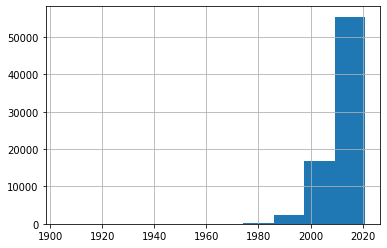

In [12]:
train['productionDate'].hist()

Как видим, в данных есть выбросы.

In [13]:
# избавляемся от выбросов в колонке с датой производства авто
Q1 = train['productionDate'].quantile(0.25)
Q3 = train['productionDate'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['productionDate']>=(Q1-1.5*IQR)) & 
              (train['productionDate']<=(Q3+1.5*IQR))]

In [14]:
train.dropna(subset=['productionDate','mileage', 'modelDate', 'enginePower', 'Привод'], inplace=True)
train.dropna(subset=['price'], inplace=True)

In [15]:
test['enginePower'] = test['enginePower'].apply(lambda x: str(x).split(' ')[0])
train['enginePower'] = train['enginePower'].apply(lambda x: str(x).split('.')[0])

In [16]:
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage', 'modelDate', 'enginePower', 'fuelType', 'Руль', 'Привод']
df_train = train[columns]
df_test = test[columns]

Преобразуем категориальные признаки в числовые

In [17]:
print(train['Руль'].unique())
print(test['Руль'].unique())

['LEFT' 'RIGHT']
['Левый' 'Правый']


In [18]:
df_train['Руль'] = (df_train['Руль'] != 'LEFT').astype('int32')
df_test['Руль'] = (df_test['Руль'] != 'Левый').astype('int32')

<ipython-input-18-8bbccc698b70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Руль'] = (df_train['Руль'] != 'LEFT').astype('int32')
<ipython-input-18-8bbccc698b70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Руль'] = (df_test['Руль'] != 'Левый').astype('int32')


In [19]:
X = pd.get_dummies(df_train['fuelType'])
df_train = pd.concat([df_train, X], axis=1)
Z = pd.get_dummies(df_test['fuelType'])
df_test = pd.concat([df_test, Z], axis=1)
df_train.drop('fuelType', inplace=True, axis=1)
df_test.drop('fuelType', inplace=True, axis=1)

In [20]:
print(train['Привод'].unique())
print(test['Привод'].unique())

['передний' 'полный' 'задний']
['передний' 'полный' 'задний']


In [21]:
X = pd.get_dummies(df_train['Привод'])
df_train = pd.concat([df_train, X], axis=1)
Z = pd.get_dummies(df_test['Привод'])
df_test = pd.concat([df_test, Z], axis=1)
df_train.drop('Привод', inplace=True, axis=1)
df_test.drop('Привод', inplace=True, axis=1)

In [22]:
y = train['price']

## Label Encoding

In [23]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [24]:
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [25]:
data

,bodyType,brand,productionDate,engineDisplacement,mileage,modelDate,enginePower,Руль,бензин,газ,гибрид,дизель,электро,задний,передний,полный,sample
0,160,29,2014,11,74000,2013.0,105,0,1,0,0,0,0,0,1,0,0
1,160,29,2017,26,60563,2017.0,110,0,1,0,0,0,0,0,1,0,0
2,160,29,2014,32,88000,2013.0,152,0,1,0,0,0,0,0,1,0,0
3,160,29,2014,26,95000,2013.0,110,0,1,0,0,0,0,0,1,0,0
4,160,29,2012,32,58536,2008.0,152,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108177,54,30,2009,92,191768,2007.0,165,0,0,0,0,1,0,0,0,1,1
108178,54,30,2006,92,260000,2004.0,163,0,0,0,0,1,0,0,0,1,1
108179,54,30,2014,69,199600,2013.0,149,0,0,0,0,1,0,0,0,1,1
108180,54,30,2014,69,133357,2013.0,149,0,0,0,0,1,0,0,0,1,1


In [26]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [27]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [28]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 163.85%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [29]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [30]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 12.08%


Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Target
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [104]:
np.log(y_train)

8687     13.641157
60961    14.151983
74783    13.353475
72165    16.163413
10952    13.060488
           ...    
37797    13.321214
6544     16.191690
55748    12.254863
1042     14.844058
16182    12.873902
Name: price, Length: 58796, dtype: float64

In [105]:
model = CatBoostRegressor(iterations = 6000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [106]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [107]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.86%


Наилучшего значения метрики удалось добиться при значении параметра iterations = 6000.

# Stacking

Далее пробуем применить стекинг.

In [28]:
X_train['enginePower'] = X_train['enginePower'].apply(lambda x: int(x))
X_test['enginePower'] = X_test['enginePower'].apply(lambda x: int(x))
X_sub['enginePower'] = X_sub['enginePower'].apply(lambda x: int(x))

<ipython-input-28-768f6d0575b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['enginePower'] = X_train['enginePower'].apply(lambda x: int(x))
<ipython-input-28-768f6d0575b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['enginePower'] = X_test['enginePower'].apply(lambda x: int(x))


In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_sub = scaler.transform(X_sub)

In [32]:
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, n_jobs=-1, cv=5)
model.fit(X_train, np.log(y_train))

In [ ]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# Submission

In [108]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_2.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.430048e+05
1,1100549428,8.522956e+05
2,1100658222,8.887913e+05
3,1100937408,6.767585e+05
4,1101037972,7.623565e+05
5,1100912634,7.817389e+05
6,1101228730,7.591983e+05
7,1100165896,4.090072e+05
8,1100768262,2.001124e+06
9,1101218501,9.575088e+05




Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing

С помощью дополнительной обработки данных, избавления от выбросов, извлечения дополнительной информации из существующих признаков и подбора параметров точность модели была улучшена с 15% до 11% на трейне и с 27% до 19.3% процентов на ЛБ.